# Electroencephalogram Signal Classification for Brain-Computer Interface

**Author:** [Okba Bekhelifi](https://github.com/okbalefthanded)<br>
**Date created:** 2025/01/08<br>
**Last modified:** 2025/01/08<br>
**Description:** A Transformer based classification for EEG signal for BCI.

# Introduction

This tutorial will explain how to build a Transformer based Neural Network to classify
Brain-Computer Interface (BCI) Electroencephalograpy (EEG) data recorded in a
Steady-State Visual Evoked Potentials (SSVEPs) experiment for the application of a
brain-controlled speller.

The tutorial reproduces an experiment from the SSVEPFormer study [1]
( [arXiv preprint](https://arxiv.org/abs/2210.04172) /
[Peer-Reviewed paper](https://www.sciencedirect.com/science/article/abs/pii/S0893608023002319) ).
This model was the first Transformer based model to be introduced for SSVEP data classification,
we will test it on the Nakanishi et al. [2] public dataset as dataset 1 from the paper.

The process follows an inter-subject classification experiment. Given N subject data in
the dataset, the training data partition contains data from N-1 subject and the remaining
single subject data is used for testing. the training set does not contain any sample from
the testing subject. This way we construct a true subject-independent model. We keep the
same parameters and settings as the original paper in all processing operations from
preprocessing to training.


The tutorial begins with a quick BCI and dataset description then, we go through the
technicalities following these sections:
- Setup, and imports.
- Dataset download and extraction.
- Data preprocessing: EEG data filtering, segmentation and visualization of raw and
filtered data, and frequency response for a well performing participant.
- Layers and model creation.
- Evaluation: a single participant data classification as an example then the total
participants data classification.
- Visulization: we show the results of training and inference times comparison among
the Keras 3 available backends (JAX, Tensorflow, and PyTorch) on three different GPUs.
- Conclusion: final discussion and remarks.

# Dataset description

## BCI and SSVEP:
A BCI offers the ability to communicate using only brain activity, this can be achieved
through exogenous stimuli that generate specific responses indicating the intent of the
subject. the responses are elicited when the user focuses their attention on the target
stimulus. We can use visual stimuli by presenting the subject with a set of options
typically on a monitor as a grid to select one command at a time. Each stimulus will
flicker following a fixed frequency and phase, the resulting EEG recorded at occipital
and occipito-parietal areas of the cortex (visual cortex) will have higher power in the
associated frequency with the stimulus where the subject was looking at. This type of
BCI paradigm is called the Steady-State Visual Evoked Potentials (SSVEPs) and became
widely used for multiple application due to its reliability and high perfromance in
classification and rapidity as a 1-second of EEG is sufficient making a command. Other
types of brain responses exists and do not require external stimulations, however they
are less reliable.
[Demo video](https://www.youtube.com/watch?v=VtA6jsEMIug)

This tutorials uses the 12 commands (class) public SSVEP dataset [2] with the following
interface emulating a phone dialing numbers.
![dataset](/img/eeg_bci_ssvepformer/eeg_ssvepformer_dataset1_interface.jpg)

The dataset was recorded with 10 participants, each faced the above 12 SSVEP stimuli (A).
The stimulation frequencies ranged from 9.25Hz to 14.75 Hz with 0.5Hz step, and phases
ranged from 0 to 1.5 π with 0.5 π step for each row.(B). The EEG signal was acquired
with 8 electrodes (channels) (PO7, PO3, POz,
PO4, PO8, O1, Oz, O2) sampling frequency was 2048 Hz then the stored data were
downsampled to 256 Hz. The subjects completed 15 blocks of recordings, each consisted
of 12 random ordered stimulations (1 for each class) of 4 seconds each. In total,
each subject conducted 180 trials.


# Setup

## Select JAX backend

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

## Install dependencies

In [2]:
!pip install -q numpy
!pip install -q scipy
!pip install -q matplotlib

# Imports


In [3]:
# deep learning libraries
from keras import backend as K
from keras import layers
import keras

# visualization and signal processing imports
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.io import loadmat

# setting the backend, seed and Keras channel format
K.set_image_data_format("channels_first")
keras.utils.set_random_seed(42)

# Download and extract dataset


## Nakanishi et. al 2015 [DataSet Repo](https://github.com/mnakanishi/12JFPM_SSVEP)

In [4]:
!curl -O https://sccn.ucsd.edu/download/cca_ssvep.zip
!unzip cca_ssvep.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  145M  100  145M    0     0  86.9M      0  0:00:01  0:00:01 --:--:-- 87.0M
Archive:  cca_ssvep.zip
   creating: cca_ssvep/
  inflating: cca_ssvep/s4.mat        
  inflating: cca_ssvep/s5.mat        
  inflating: cca_ssvep/s3.mat        
  inflating: cca_ssvep/s7.mat        
  inflating: cca_ssvep/chan_locs.pdf  
  inflating: cca_ssvep/readme.txt    
  inflating: cca_ssvep/s2.mat        
  inflating: cca_ssvep/s8.mat        
  inflating: cca_ssvep/s10.mat       
  inflating: cca_ssvep/s9.mat        
  inflating: cca_ssvep/s6.mat        
  inflating: cca_ssvep/s1.mat        


# Pre-Processing

The preprocessing steps followed are first to read the EEG data for each subject, then
to filter the raw data in a frequency interval where most useful information lies,
then we select a fixed duration of signal starting from the onset of the stimulation
(due to latency delay caused by the visual system we start we add 135 milliseconds to
the stimulation onset). Lastly, all subjects data are concatenated in a single Tensor
of the shape: [subjects x samples x channels x trials]. The data labels are also
concatenated following the order of the trials in the experiments and will be a
matrix of the shape [subjects x trials]
(here by channels we mean electrodes, we use this notation throughout the tutorial).

In [5]:

def raw_signal(folder, fs=256, duration=1.0, onset=0.135):
    """selecting a 1-second segment of the raw EEG signal for
    subject 1.
    """
    onset = 38 + int(onset * fs)
    end = int(duration * fs)
    data = loadmat(f"{folder}/s1.mat")
    # samples, channels, trials, targets
    eeg = data["eeg"].transpose((2, 1, 3, 0))
    # segment data
    eeg = eeg[onset : onset + end, :, :, :]
    return eeg


def segment_eeg(
    folder, elecs=None, fs=256, duration=1.0, band=[5.0, 45.0], order=4, onset=0.135
):
    """Filtering and segmenting EEG signals for all subjects."""
    n_subejects = 10
    onset = 38 + int(onset * fs)
    end = int(duration * fs)
    X, Y = [], []  # empty data and labels

    for subj in range(1, n_subejects + 1):
        data = loadmat(f"{data_folder}/s{subj}.mat")
        # samples, channels, trials, targets
        eeg = data["eeg"].transpose((2, 1, 3, 0))
        # filter data
        eeg = filter_eeg(eeg, fs=fs, band=band, order=order)
        # segment data
        eeg = eeg[onset : onset + end, :, :, :]
        # reshape labels
        samples, channels, blocks, targets = eeg.shape
        y = np.tile(np.arange(1, targets + 1), (blocks, 1))
        y = y.reshape((1, blocks * targets), order="F")

        X.append(eeg.reshape((samples, channels, blocks * targets), order="F"))
        Y.append(y)

    X = np.array(X, dtype=np.float32, order="F")
    Y = np.array(Y, dtype=np.float32).squeeze()

    return X, Y


def filter_eeg(data, fs=256, band=[5.0, 45.0], order=4):
    """Filter EEG signal using a zero-phase IIR filter"""
    B, A = butter(order, np.array(band) / (fs / 2), btype="bandpass")
    return filtfilt(B, A, data, axis=0)


## Segment data into epochs

In [6]:
data_folder = os.path.abspath("./cca_ssvep")
band = [8, 64]  # low-frequency / high-frequency cutoffS
order = 4  # filter order
fs = 256  # sampling frequency
duration = 1.0  # 1 second

# raw signal
X_raw = raw_signal(data_folder, fs=fs, duration=duration)
print(
    f"A single subject raw EEG (X_raw) shape: {X_raw.shape} [Samples x Channels x Blocks x Targets]"
)

# segmented signal
X, Y = segment_eeg(data_folder, band=band, order=order, fs=fs, duration=duration)
print(
    f"Full training data (X) shape: {X.shape} [Subject x Samples x Channels x Trials]"
)
print(f"data labels (Y) shape:        {Y.shape} [Subject x Trials]")

samples = X.shape[1]
time = np.linspace(0.0, samples / fs, samples) * 1000

A single subject raw EEG (X_raw) shape: (256, 8, 15, 12) [Samples x Channels x Blocks x Targets]
Full training data (X) shape: (10, 256, 8, 180) [Subject x Samples x Channels x Trials]
data labels (Y) shape:        (10, 180) [Subject x Trials]


## Visualize EEG signal

## EEG in time

Raw EEG vs Filtered EEG
The same 1-second recording for subject s1 at Oz (central electrode in the visual cortex,
back of the head) is illustrated. left is the raw EEG as recorded and in the right is
the filtered EEG on the [8, 64] Hz frequency band. we see less noise and
normalized amplitude values in a natural EEG range.

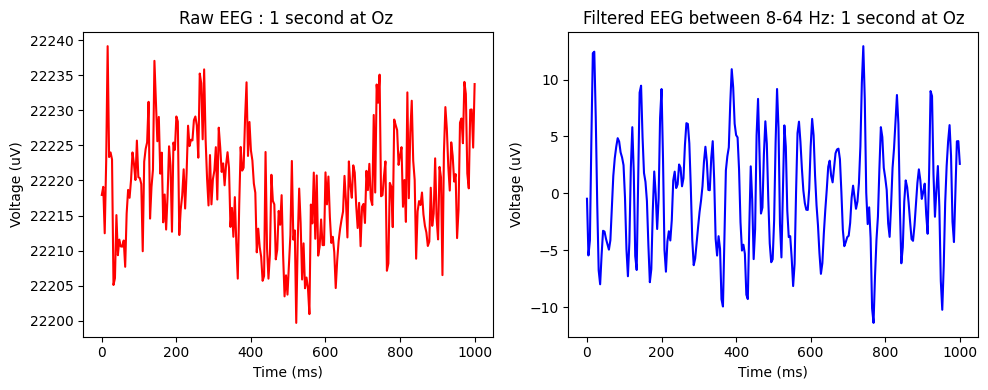

In [7]:

elec = 6  # Oz channel

x_label = "Time (ms)"
y_label = "Voltage (uV)"
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot data on the first subplot
ax1.plot(time, X_raw[:, elec, 0, 0], "r-")
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax1.set_title("Raw EEG : 1 second at Oz ")

# Plot data on the second subplot
ax2.plot(time, X[0, :, elec, 0], "b-")
ax2.set_xlabel(x_label)
ax2.set_ylabel(y_label)
ax2.set_title("Filtered EEG between 8-64 Hz: 1 second at Oz")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## EEG frequency representation

Using the welch method, we visualize the frequency power for a well performing subject
for the entire 4 seconds EEG recording at Oz electrode for each stimuli. the red peaks
indicate the stimuli fundamental frequency and the 2nd harmonics (double the fundamental
frequency). we see clear peaks showing the high responses from that subject which means
that this subject is a good candidate for SSVEP BCI control. In many cases the peaks
are weak or absent, meaning that subject do not achieve the task correctly.

![eeg_frequency](/img/eeg_bci_ssvepformer/eeg_ssvepformer_frequencypowers.png)

# Create Layers and model

Create Layers in a cross-framework custom component fashion.
In the SSVEPFormer, the data is first transformed to the frequency domain through
Fast-Fourier transform (FFT), to construct a complex spectrum presentation consisting of
the concatenation of frequency and phase information in a fixed frequency band. To keep
the model in an end-to-end format, we implement the complex spectrum transformation as
non-trainable layer.

![model](/img/eeg_bci_ssvepformer/eeg_ssvepformer_model.jpg)
The SSVEPFormer unlike the Transformer architecture does not contain positional encoding/embedding
layers which replaced a channel combination block that has a layer of Conv1D layer of 1
kernel size with double input channels (double the count of electrodes) number of filters,
and LayerNorm, Gelu activation and dropout.
Another difference with Transformers is the absence of multi-head attention layers with
attention mechanism.
The model encoder contains two identical and successive blocks. Each block has two
sub-blocks of CNN module and MLP module. the CNN module consists of a LayerNorm, Conv1D
with the same number of filters as channel combination, LayerNorm, Gelu, Dropout and an
residual connection. The MLP module consists of a LayerNorm, Dense layer, Gelu, droput
and residual connection. the Dense layer is applied on each channel separately.
The last block of the model is MLP head with Flatten layer, Dropout, Dense, LayerNorm,
Gelu, Dropout and Dense layer with softmax acitvation.
All trainable weights are initialized by a normal distribution with 0 mean and 0.01
standard deviation as state in the original paper.

In [8]:

class ComplexSpectrum(keras.layers.Layer):
    def __init__(self, nfft=512, fft_start=8, fft_end=64):
        super().__init__()
        self.nfft = nfft
        self.fft_start = fft_start
        self.fft_end = fft_end

    def call(self, x):
        samples = x.shape[-1]
        x = keras.ops.rfft(x, fft_length=self.nfft)
        real = x[0] / samples
        imag = x[1] / samples
        real = real[:, :, self.fft_start : self.fft_end]
        imag = imag[:, :, self.fft_start : self.fft_end]
        x = keras.ops.concatenate((real, imag), axis=-1)
        return x


class ChannelComb(keras.layers.Layer):
    def __init__(self, n_channels, drop_rate=0.5):
        super().__init__()
        self.conv = layers.Conv1D(
            2 * n_channels,
            1,
            padding="same",
            kernel_initializer=keras.initializers.RandomNormal(
                mean=0.0, stddev=0.01, seed=None
            ),
        )
        self.normalization = layers.LayerNormalization()
        self.activation = layers.Activation(activation="gelu")
        self.drop = layers.Dropout(drop_rate)

    def call(self, x):
        x = self.conv(x)
        x = self.normalization(x)
        x = self.activation(x)
        x = self.drop(x)
        return x


class ConvAttention(keras.layers.Layer):
    def __init__(self, n_channels, drop_rate=0.5):
        super().__init__()
        self.norm = layers.LayerNormalization()
        self.conv = layers.Conv1D(
            2 * n_channels,
            31,
            padding="same",
            kernel_initializer=keras.initializers.RandomNormal(
                mean=0.0, stddev=0.01, seed=None
            ),
        )
        self.activation = layers.Activation(activation="gelu")
        self.drop = layers.Dropout(drop_rate)

    def call(self, x):
        input = x
        x = self.norm(x)
        x = self.conv(x)
        x = self.activation(x)
        x = self.drop(x)
        x = x + input
        return x


class ChannelMLP(keras.layers.Layer):
    def __init__(self, n_features, drop_rate=0.5):
        super().__init__()
        self.norm = layers.LayerNormalization()
        self.mlp = layers.Dense(
            2 * n_features,
            kernel_initializer=keras.initializers.RandomNormal(
                mean=0.0, stddev=0.01, seed=None
            ),
        )
        self.activation = layers.Activation(activation="gelu")
        self.drop = layers.Dropout(drop_rate)
        self.cat = layers.Concatenate(axis=1)

    def call(self, x):
        input = x
        channels = x.shape[1]  # x shape : NCF
        x = self.norm(x)
        output_channels = []
        for i in range(channels):
            c = self.mlp(x[:, :, i])
            c = layers.Reshape([1, -1])(c)
            output_channels.append(c)
        x = self.cat(output_channels)
        x = self.activation(x)
        x = self.drop(x)
        x = x + input
        return x


class Encoder(keras.layers.Layer):
    def __init__(self, n_channels, n_features, drop_rate=0.5):
        super().__init__()
        self.attention1 = ConvAttention(n_channels, drop_rate=drop_rate)
        self.mlp1 = ChannelMLP(n_features, drop_rate=drop_rate)
        self.attention2 = ConvAttention(n_channels, drop_rate=drop_rate)
        self.mlp2 = ChannelMLP(n_features, drop_rate=drop_rate)

    def call(self, x):
        x = self.attention1(x)
        x = self.mlp1(x)
        x = self.attention2(x)
        x = self.mlp2(x)
        return x


class MlpHead(keras.layers.Layer):
    def __init__(self, n_classes, drop_rate=0.5):
        super().__init__()
        self.flatten = layers.Flatten()
        self.drop = layers.Dropout(drop_rate)
        self.linear1 = layers.Dense(
            6 * n_classes,
            kernel_initializer=keras.initializers.RandomNormal(
                mean=0.0, stddev=0.01, seed=None
            ),
        )
        self.norm = layers.LayerNormalization()
        self.activation = layers.Activation(activation="gelu")
        self.drop2 = layers.Dropout(drop_rate)
        self.linear2 = layers.Dense(
            n_classes,
            kernel_initializer=keras.initializers.RandomNormal(
                mean=0.0, stddev=0.01, seed=None
            ),
        )

    def call(self, x):
        x = self.flatten(x)
        x = self.drop(x)
        x = self.linear1(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.drop2(x)
        x = self.linear2(x)
        return x


###  Create a sequential model with the layers above

In [9]:

def create_ssvepformer(
    input_shape, fs, resolution, fq_band, n_channels, n_classes, drop_rate
):
    nfft = round(fs / resolution)
    fft_start = int(fq_band[0] / resolution)
    fft_end = int(fq_band[1] / resolution) + 1
    n_features = fft_end - fft_start

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            ComplexSpectrum(nfft, fft_start, fft_end),
            ChannelComb(n_channels=n_channels, drop_rate=drop_rate),
            Encoder(n_channels=n_channels, n_features=n_features, drop_rate=drop_rate),
            Encoder(n_channels=n_channels, n_features=n_features, drop_rate=drop_rate),
            MlpHead(n_classes=n_classes, drop_rate=drop_rate),
            layers.Activation(activation="softmax"),
        ]
    )

    return model


# Evaluation

In [10]:
# Training settings same as the original paper
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.001  # learning rate
WD = 0.001  # weight decay
MOMENTUM = 0.9
DROP_RATE = 0.5

resolution = 0.25

From the entire dataset we select folds for each subject evaluation.
construct a tf dataset object for train and testing data and create the model and launch
the training using SGD optimizer.

In [11]:

def concatenate_subjects(x, y, fold):
    X = np.concatenate([x[idx] for idx in fold], axis=-1)
    Y = np.concatenate([y[idx] for idx in fold], axis=-1)
    X = X.transpose((2, 1, 0))  # trials x channels x samples
    return X, Y - 1  # transform labels to values from 0...11


def evaluate_subject(
    x_train,
    y_train,
    x_val,
    y_val,
    input_shape,
    fs=256,
    resolution=0.25,
    band=[8, 64],
    channels=8,
    n_classes=12,
    drop_rate=DROP_RATE,
):

    train_dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    test_dataset = (
        tf.data.Dataset.from_tensor_slices((x_val, y_val))
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

    model = create_ssvepformer(
        input_shape, fs, resolution, band, channels, n_classes, drop_rate
    )
    sgd = keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM, weight_decay=WD)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=sgd,
        metrics=["accuracy"],
        jit_compile=True,
    )

    history = model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=test_dataset,
        verbose=0,
    )
    loss, acc = model.evaluate(test_dataset)
    return acc * 100


## Run evaluation

In [12]:
channels = X.shape[2]
samples = X.shape[1]
input_shape = (channels, samples)
n_classes = 12

model = create_ssvepformer(
    input_shape, fs, resolution, band, channels, n_classes, DROP_RATE
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ complex_spectrum                │ (None, 8, 450)         │             0 │
│ (ComplexSpectrum)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_comb (ChannelComb)      │ (None, 16, 450)        │         1,044 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Encoder)               │ (None, 16, 450)        │        34,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Encoder)             │ (None, 16, 450)        │        34,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_head (MlpHead)              │ (None, 12)             │       519,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 12)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,144 (2.25 MB)

 Trainable params: 590,144 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

## Evaluation on all subjects following a leave-one-subject out data repartition scheme

In [13]:
accs = np.zeros(10)

for subject in range(10):
    print(f"Testing subject: {subject+ 1}")

    # create train / test folds
    folds = np.delete(np.arange(10), subject)
    train_index = folds
    test_index = [subject]

    # create data split for each subject
    x_train, y_train = concatenate_subjects(X, Y, train_index)
    x_val, y_val = concatenate_subjects(X, Y, test_index)

    # train and evaluate a fold and compute the time it takes
    acc = evaluate_subject(x_train, y_train, x_val, y_val, input_shape)

    accs[subject] = acc

print(f"\nAccuracy Across Subjects: {accs.mean()} % std: {np.std(accs)}")

Testing subject: 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5442 - loss: 1.4539
Testing subject: 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5241 - loss: 1.5889
Testing subject: 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6714 - loss: 1.0288
Testing subject: 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9484 - loss: 0.1682
Testing subject: 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9243 - loss: 0.2756
Testing subject: 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9547 - loss: 0.1165
Testing subject: 7
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9221 - loss: 0.2404
Testing subject: 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9937 - loss: 0.0559
Testing subject: 9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9674 - loss: 0.1143
Testing subject: 10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8810 - loss: 0.4136

Accuracy Across Subjects: 83.05555760860443 % std: 17.612514024347398


and that's it! we see how some subjects with no data on the training set still can achieve
almost a 100% correct commands and others show poor performance around 50%. In the original
paper using PyTorch the average accuracy was 84.04% with 17.37 std. we reached the same
values knowing the stochastic nature of deep learning.

# Visualizations

Training and inference times comparison between the different backends (Jax, Tensorflow
and PyTorch) on the three GPUs available with Colab Free/Pro/Pro+: T4, L4, A100.


## Training Time

![training_time](/img/eeg_bci_ssvepformer/eeg_ssvepformer_keras_training_time.png)

# Inference Time

![inference_time](/img/eeg_bci_ssvepformer/eeg_ssvepformer_keras_inference_time.png)

the Jax backend was the best on training and inference in all the GPUs, the PyTorch was
exremely slow due to the jit compilation option being disable because of the complex
data type calculated by FFT which is not supported by the PyTorch jit compiler.

# Acknowledgment

I thank Chris Perry [X](https://x.com/thechrisperry) @GoogleColab for supporting this
work with GPU compute.

# References
[1] Chen, J. et al. (2023) ‘A transformer-based deep neural network model for SSVEP
classification’, Neural Networks, 164, pp. 521–534. Available at: https://doi.org/10.1016/j.neunet.2023.04.045.

[2] Nakanishi, M. et al. (2015) ‘A Comparison Study of Canonical Correlation Analysis
Based Methods for Detecting Steady-State Visual Evoked Potentials’, Plos One, 10(10), p.
e0140703. Available at: https://doi.org/10.1371/journal.pone.0140703